## Installing dependencies

 - Have python3 running on your machine
 - Create a virtual environment `python3 -m venv venv` in your current working directory
 - Enter the virtual environment `source .venv/bin/activate`, run `pip install -r requirements.txt` to install all dependencies

----



In [12]:
import pandas as pd
import numpy as np
import matplot as mp
import matplotlib.pyplot as plt
import seaborn as sns
import random
import json
from collections import defaultdict

teams = []

## Question 1: Temperature Modeling

Consider a scenario where the temperature $X(t)$ varies randomly over a continuous time interval $t$, where $t$ is in the range from 0 to 1. We begin with the assumption that $X(0) = 0$, which means that the temperature at time 0 is 0. Now, if we choose a small time increment represented by ∆t, we can make the assumption that the change in temperature from time $t$ to $t + ∆t$, denoted as $X(t+ ∆t)− X(t)$, follows a normal distribution. This normal distribution is characterized by a mean of 0 and a variance of ∆t.

1. Let $P$ be the random variable denoting the proportion of time in [0, 1] such that the temperature is positive. Estimate the distribution of $P$ by Monte Carlo simulation and experimenting with various values of ∆t (e.g. ∆t = 0.01, 0.001, 0.0001, · · · .)
2. Let $T_{max}$ be the random variable denoting the time in [0, 1] such that the temperature is at its maximum. Estimate the distribution of $T_{max}$ by Monte Carlo simulation and experimenting with various values of ∆t (e.g. ∆t = 0.01, 0.001, 0.0001, · · · .)

We will first plot the distribution estimate for $P$ when $∆t = 0.01$. We will pick the number of simulations to be 1000. Since the temperature change from some time $t$ to $t + ∆t$ is normally distributed, within each simulation we will sample $1/∆t$ values from a normal distribution with 0 mean and $\sqrt∆t$ standard deviation. Then, starting from time 0 and temperature 0, we will add the temperature changes one by one, and for each change record whether the current temperature is positive or not.

In [10]:
# Parameters we can choose

deltaT = 0.01
num_simulations = 1000

Formally, for $n=\frac{1}{\Delta t}$ samples $\left\{ s_1, s_2, \dots, s_n \right\}$, we define the proportion of positive temperatures $p$ as
$p=\frac{1}{n}\sum_{k=1}^{n}\textbf{1}_\mathbb{R^+}\left( \sum_{i=1}^{k} s_i \right)$, where $\textbf{1}_\mathbb{R^+}$ is the indicator function of the set of positive reals, defined as
$$
\textbf{1}_\mathbb{R^+}(x) =
\begin{cases}
1 & \text{if } x \in R^+, \\
0 & \text{if } x \notin R^+.
\end{cases}
$$

In [8]:
def get_positive_proportion(arr):
    num = cur = 0
    for t in arr:
        cur += t
        num += int(cur > 0)
    return num / arr.shape[0]

def get_P(deltaT, num_simulations=1000):
    num_temp_changes = int(1 / deltaT)
    temp_changes = np.random.normal(0, np.sqrt(deltaT), (num_simulations, num_temp_changes))
    return np.array(list(map(get_positive_proportion, temp_changes)))

Finally, we plot the computed values of $\left\{ p_1, p_2, \dots, p_m \right\}$ where $m$ is the number of simulations performed ($m=1000$ in our case).

Text(0, 0.5, 'Frequency')

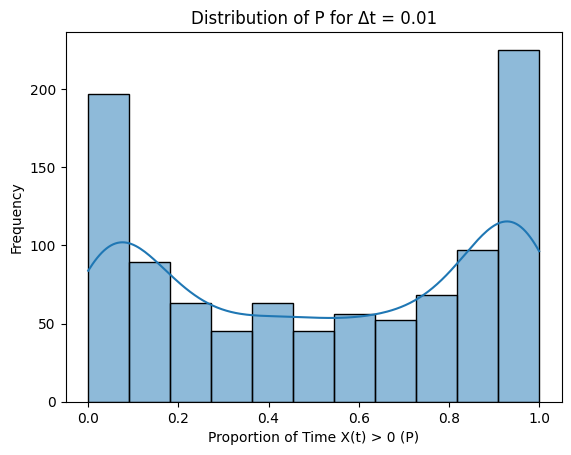

In [13]:
proportions = get_P(deltaT, num_simulations)
sns.histplot(proportions, kde=True)
plt.title(f'Distribution of P for Δt = {deltaT}')
plt.xlabel('Proportion of Time X(t) > 0 (P)')
plt.ylabel('Frequency')

Next step is to plot the distribution estimates for $\Delta t = 0.01, 0.001, 0.0001, 0.00001$.

In [14]:
deltaTs = [0.01, 0.001, 0.0001, 0.00001]
P_values = [get_P(delta_t) for delta_t in deltaTs]

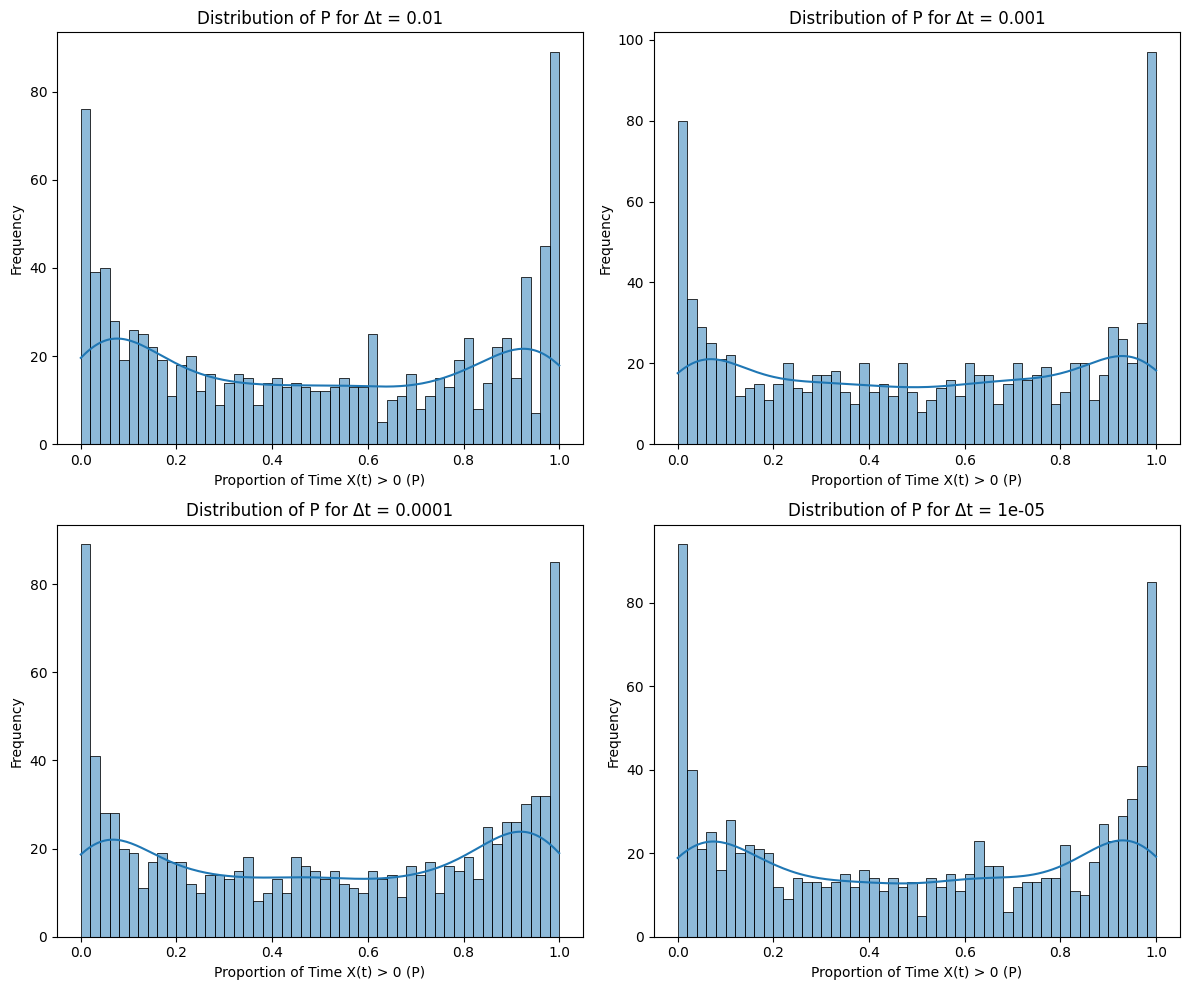

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, P_value in enumerate(P_values):
    sns.histplot(P_value, kde=True, bins=50, ax=axes[idx])
    axes[idx].set_title(f'Distribution of P for Δt = {deltaTs[idx]}')
    axes[idx].set_xlabel('Proportion of Time X(t) > 0 (P)')
    axes[idx].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

The following table contains mean and variance estimates for value of $\Delta t$.

In [48]:
means = [p.mean() for p in P_values]
vars = [p.var() for p in P_values]
dist_df = pd.DataFrame(list(zip(deltaTs, means, vars)), columns=['Δt', 'Mean', 'Variance'])
dist_df

,Δt,Mean,Variance
0,0.01000,0.485990,0.124607
1,0.00100,0.506686,0.119033
2,0.00010,0.507017,0.124882
3,0.00001,0.500387,0.125853


Now we turn to estimating the distribution of $T_{max}$. Similarly to $P$, The time at which the temperature is at its maximum can be defined as $t_{max}=\frac{1}{n}\underset{k \in S}{\argmax} \left( \sum_{i=1}^{k} s_i \right)$ where $n=\frac{1}{\Delta t}$, $\left\{ s_1, s_2, \dots, s_n \right\}$ are the temperature change samples and $S=\left\{ x \in \mathbb{N} \mid x \le n \right\}$.

In [49]:
def get_max(arr):
    max_val = max_ind = cur = 0
    for i in range(arr.shape[0]):
        cur += arr[i]
        max_val = max(max_val, cur)
        max_ind = i if max_val == cur else max_ind

    return max_ind / arr.shape[0]

def get_Tmax(deltaT, num_simulations=1000):
    num_temp_changes = int(1 / deltaT)
    temp_changes = np.random.normal(0, np.sqrt(deltaT), (num_simulations, num_temp_changes))
    return np.array(list(map(get_max, temp_changes)))

In [51]:
Tmax_values = [get_Tmax(delta_t) for delta_t in deltaTs]

The following are the distribution estimates for $T_{max}$ when $\Delta t = 0.01, 0.001, 0.0001, 0.00001$.

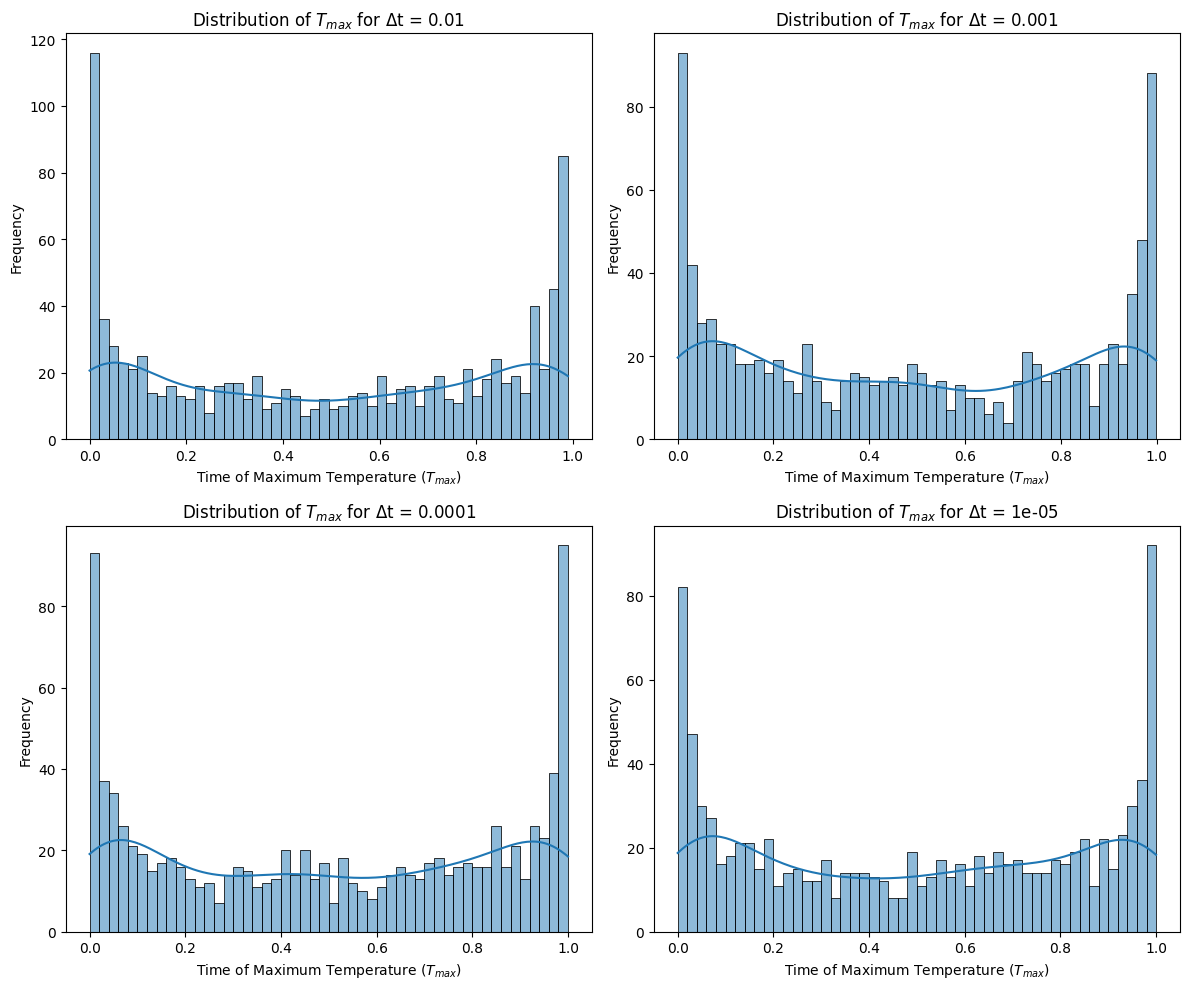

In [54]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, Tmax_value in enumerate(Tmax_values):
    sns.histplot(Tmax_value, kde=True, bins=50, ax=axes[idx])
    axes[idx].set_title(f'Distribution of $T_{{max}}$ for Δt = {deltaTs[idx]}')
    axes[idx].set_xlabel('Time of Maximum Temperature ($T_{max}$)')
    axes[idx].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

The following table contains mean and variance estimates for value of $\Delta t$.

In [55]:
means = [t.mean() for t in Tmax_values]
vars = [t.var() for t in Tmax_values]
dist_df = pd.DataFrame(list(zip(deltaTs, means, vars)), columns=['Δt', 'Mean', 'Variance'])
dist_df

,Δt,Mean,Variance
0,0.01000,0.490810,0.128790
1,0.00100,0.489430,0.127302
2,0.00010,0.501858,0.124305
3,0.00001,0.501008,0.123100


### Analysis of Results

Distribution estimates of $P$ and $T_{max}$ seem to suggest that both random variables have identical distributions, with $\mu \approx 0.5$ and $\sigma^2 \approx 0.125$. A notable characteristic of both distributions are the heavy tails at 0 and 1. Simulating how the temperature changes over time for a few samples, we notice that some paths keep hovering over 0, shifting from positive to negative and negative and positive values. However, a good portion of paths start with a wave of positive/negative changes, and thus never go down/up to 0. These samples will have either $t_{max}=p=0$ (negative values at start) or $t_{max}=p=1.0$ (positive values at start).

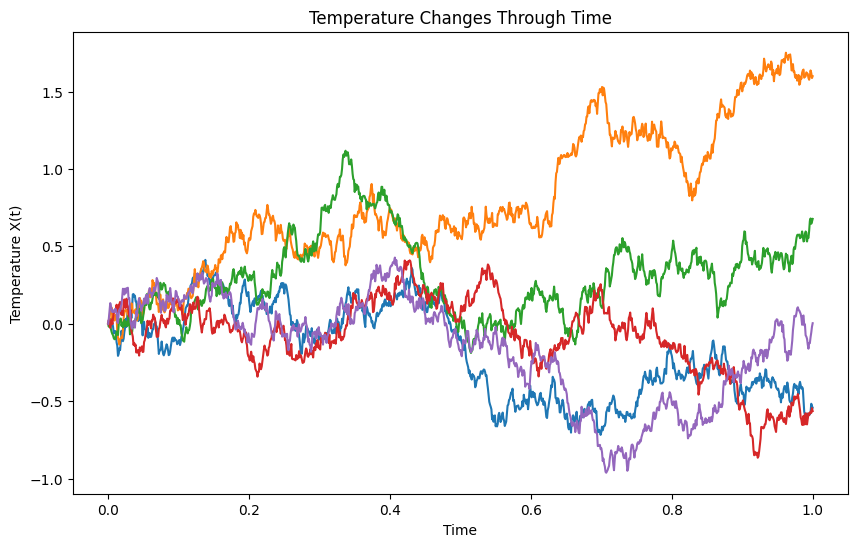

In [66]:
def simulate_change(delta_t):
    N_steps = int(1 / delta_t)
    dX = np.random.normal(0, np.sqrt(delta_t), size=N_steps)
    X = np.concatenate(([0], np.cumsum(dX)))
    time_grid = np.linspace(0, 1, N_steps + 1)
    return time_grid, X

delta_t = 0.001
num_paths = 5
plt.figure(figsize=(10, 6))

for _ in range(num_paths):
    t, X = simulate_change(delta_t)
    plt.plot(t, X)

plt.title('Temperature Changes Through Time')
plt.xlabel('Time')
plt.ylabel('Temperature X(t)')
plt.show()


# Question 2: Premier League Forecasting

Create a probabilistic model and perform Monte Carlo simulations to forecast the final points for Premier League teams in the 2024-2025 season. 

This model will include some unknown parameters that you will determine based on the data you gather. 

In Premier League matches, teams earn three points for a win, one point for a draw, and no points for a loss. For your predictions, you could use statistics from the beginning of the season up to a specific date to estimate the parameters of your model, and then run Monte Carlo simulations to project the outcomes of the remaining matches, ultimately predicting the final points for each team at the season's end. 

----

Here's a brief outline of a relatively straightforward way to model this scenario. 

For each match, you can treat the number of shots attempted by the home and away teams as random variables, such as Poisson random variables. The rate parameters of the Poisson distribution will be influenced by the strengths of both teams. Each shot taken will have an associated probability of scoring, which also varies depending on the teams involved. 

You are encouraged to create your own models, but it's essential to explain and justify your choices. Discuss how you determine the parameters and outline the advantages and limitations of the models you select.

-----
## Question 2: Premier League Forecasting:

The script datascraper.py extracts a large quantity of player statistics from the website https://www.fbref.com and returnst to us a *players.json* file that we can use for our predictive model.

The general principle of our simulation is a time based simulation. I.E we start the game off with a random player from the home team (excluding the gk) taking the kick-off. When it is taken he will pass to another random player (excluding the keeper). We then simulate the players chances of either passing, shooting, keeping or losing the ball.

We need to use this data to model a large number of things:
1) Team Lineups
2) 


#### Team Lineup Creation Function:

In [16]:

def predict_starting_lineup(team_name, iterations=10000, file_path ="./players.json"):
    """
    Predict the starting lineup for a team using a Monte Carlo simulation.

    Parameters:
        file_path (str): Path to the JSON file containing player stats.
        team_name (str): The name of the team to predict the lineup for.
        iterations (int): Number of Monte Carlo iterations.

    Returns:
        dict: Predicted starting lineup with 4 defenders, 3 midfielders, 3 forwards, and 1 goalkeeper.
    """
    #Assign numberDefenders, numberAttackers, numberMidfielders
    with open("./teamFormations.json", 'r') as formationFile:
        formations = json.load(formationFile)

    lineup = "4,3,3"
    for formation in formations:
        if formation["name"] == team_name:
            lineup = formation["formation"]
        
    # Load player data from file
    with open(file_path, 'r') as file:
        players = json.load(file)
    
    lineup = lineup.split(",")

    # Filter players for the specified team
    team_players = [player for player in players if player['team'] == team_name]

    if not team_players:
        raise ValueError(f"No players found for team {team_name}")

    # Separate players by position, accounting for multiple positions
    defenders = [p for p in team_players if 'DF' in p['position'].split(', ')]
    midfielders = [p for p in team_players if 'MF' in p['position'].split(', ')]
    forwards = [p for p in team_players if 'FW' in p['position'].split(', ')]
    goalkeepers = [p for p in team_players if 'GK' in p['position'].split(', ')]

    if not goalkeepers:
        raise ValueError(f"No goalkeepers found for team {team_name}")

    # Monte Carlo simulation to predict lineup
    defender_selection_counts = defaultdict(int)
    midfielder_selection_counts = defaultdict(int)
    forward_selection_counts = defaultdict(int)
    goalkeeper_selection_counts = defaultdict(int)

    for _ in range(iterations):
        # Randomly choose 4 defenders weighted by games played
        selected_defenders = random.choices(
            defenders,
            weights=[p['gamesPlayedForCurrentTeam'] if p['gamesPlayedForCurrentTeam'] > 0 else 1 for p in defenders],
            k= int(lineup[0])
        )

        # Randomly choose 3 midfielders weighted by games played
        selected_midfielders = random.choices(
            midfielders,
            weights=[p['gamesPlayedForCurrentTeam'] if p['gamesPlayedForCurrentTeam'] > 0 else 1 for p in midfielders],
            k= int(lineup[1])
        )

        # Randomly choose 3 forwards weighted by games played
        selected_forwards = random.choices(
            forwards,
            weights=[p['gamesPlayedForCurrentTeam'] if p['gamesPlayedForCurrentTeam'] > 0 else 1 for p in forwards],
            k= int(lineup[2])
        )

        # Randomly choose 1 goalkeeper weighted by starts/games ratio
        selected_goalkeeper = random.choices(
            goalkeepers,
            weights=[p['gamesPlayedForCurrentTeam'] if p['gamesPlayedForCurrentTeam'] > 0 else 1 for p in goalkeepers],
            k=1
        )[0]

        # Increment selection counts
        for player in selected_defenders:
            defender_selection_counts[player['name']] += 1
        for player in selected_midfielders:
            midfielder_selection_counts[player['name']] += 1
        for player in selected_forwards:
            forward_selection_counts[player['name']] += 1
        goalkeeper_selection_counts[selected_goalkeeper['name']] += 1

    # Determine the most likely starting lineup
    predicted_defenders = sorted(
        defender_selection_counts.items(),
        key=lambda x: x[1],
        reverse=True
    )[:int(lineup[0])]

    predicted_midfielders = sorted(
        midfielder_selection_counts.items(),
        key=lambda x: x[1],
        reverse=True
    )[:int(lineup[1])]

    predicted_forwards = sorted(
        forward_selection_counts.items(),
        key=lambda x: x[1],
        reverse=True
    )[:int(lineup[2])]

    predicted_goalkeeper = max(goalkeeper_selection_counts.items(), key=lambda x: x[1])

    # Format the result
    lineup = {
        'goalkeeper': predicted_goalkeeper[0],
        'defenders': [player[0] for player in predicted_defenders],
        'midfielders': [player[0] for player in predicted_midfielders],
        'forwards': [player[0] for player in predicted_forwards]
    }

    return lineup


#Creates an array of the team names!
with open("./teamFormations.json", 'r') as teamFile:
        teamsJSON = json.load(teamFile)
for team in teamsJSON:
    teams.append(team['name'])

print(predict_starting_lineup("Chelsea"))









{'goalkeeper': 'Robert Sánchez', 'defenders': ['Marc Cucurella', 'Malo Gusto', 'Reece James', 'Axel Disasi'], 'midfielders': ['Moisés Caicedo', 'Cesare Casadei', 'Roméo Lavia', 'Kiernan Dewsbury-Hall', 'Enzo Fernández'], 'forwards': ['Nicolas Jackson']}
